In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
#from tqdm.notebook import tqdm
from os.path import exists
import matplotlib.pyplot as plt
lr = 0.5 #скорость обучения
batch_size = 256
dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

In [3]:
download = not exists('./data')
train_set = datasets.MNIST(root='./data', train=True, download=download, transform=None)
test_set = datasets.MNIST(root='./data', train=False, download=download, transform=None)

0it [00:00, ?it/s]

9920512it [00:03, 2598418.08it/s]                                                                                      


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 66295.71it/s]                                                                                          
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


1654784it [00:01, 1461628.50it/s]                                                                                      
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


8192it [00:02, 3054.72it/s]                                                                                            


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [3]:
x_train, y_train = train_set.data, train_set.targets
x_test, y_test = test_set.data, test_set.targets
#переводит во float и по надобности перекидывает на видеокарту
x_train = x_train.float().to(device)
x_test = x_test.float().to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [4]:
#смотрим данные
print(x_train.shape,'\n__________________________________________\n',y_train.shape)
print(f'максимальное значение: {x_train.max()}')

torch.Size([60000, 28, 28]) 
__________________________________________
 torch.Size([60000])
максимальное значение: 255.0


In [5]:
x_train = x_train.reshape(-1, 28*28)#сделаем плоский массив
x_test = x_test.reshape(-1, 28*28)
#т.к. таргет просто метка, а не one-hot, используется хитрая функция scatter для получения one-hot encoding
y_test = torch.zeros(len(y_test), 10).to(device).scatter(1,y_test.reshape(-1,1), 1)
y_train = torch.zeros(len(y_train), 10).to(device).scatter(1,y_train.reshape(-1,1), 1)

In [6]:
y_train.shape

torch.Size([60000, 10])

In [7]:
#понимаем, что данные надо отнормировать
x_train /= 255
x_test /= 255

In [8]:
#DataLoader - просто обёртка над датасетом, которая выплёвывает данные батчами(по сколько-то штук) и перемешивает их
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,shuffle=True)

In [9]:
#обучим softmax-регрессию!
W = torch.zeros(784, 10, requires_grad = True, device = device, dtype = dtype)
b = torch.zeros(10, requires_grad = True, device = device, dtype = dtype)

In [10]:
def loss_plot(fig, ax, train_loss, test_loss, loss_name):
    train_line = ax.plot(train_loss, color = 'black')
    test_line = ax.plot(test_loss, color = 'red')
    #рисуем вертикальные линии с эпохами
    i = 1
    while i * len(train_loader) < len(train_loss):
        ax.axvline(i * len(train_loader), linestyle = '--')
        i += 1
    ax.set_xlabel('Батч')
    ax.set_ylabel(loss_name)
    ax.legend(('Тренировочная выборка', 'Тестовая выборка'))
    fig.canvas.draw()

In [11]:
#создаём софтмакс, который "софтмаксит" по строкам
def softmax(x):
    sums = torch.sum(torch.exp(x), dim = 1).reshape(-1, 1)
    return torch.exp(x) / sums

In [12]:
torch.mean((torch.argmax(y_test, 1) == torch.argmax(y_test, 1)).float()) 

tensor(1., device='cuda:0')

<IPython.core.display.Javascript object>


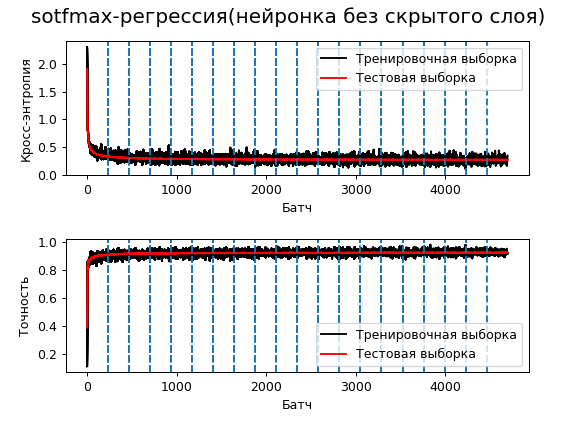

In [13]:
%matplotlib notebook
fig,ax = plt.subplots(2,1)
#дистанция между графиками на фигуре
fig.tight_layout(pad=3.0)
ax1, ax2 = ax
train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = 20
for i in range(epochs):
    for x, y in train_loader:
        y_hat = softmax(torch.matmul(x, W) + b)
        cross_entropy = torch.mean(-torch.sum(y * torch.log(y_hat), dim = 1))
        train_loss.append(cross_entropy.item())
        train_acc.append(
            torch.mean((torch.argmax(y, 1) == torch.argmax(y_hat, 1)).float()))
        #подсчёт градиентов
        cross_entropy.backward()
        #обновление параметров
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            # зануляем градиент
            W.grad.zero_()
            b.grad.zero_()
            #считаем значения на тестовой выборке
            y_hat = softmax(torch.matmul(x_test, W) + b)
            test_loss.append(torch.mean(-torch.sum(y_test * torch.log(y_hat), dim = 1)))
            test_acc.append(
                torch.mean((torch.argmax(y_test, 1) == torch.argmax(y_hat, 1)).float())) 
    
        #функция, которая сбрасывает весь предыдущий градиент
        #optimizer.zero_grad()
    fig.suptitle('sotfmax-регрессия(нейронка без скрытого слоя)', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")
    loss_plot(fig,ax2,train_acc, test_acc, "Точность")
    

# Тот же самый код написан в MNIST_softreg.ipynb,  но более декларативно